In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os

#### Read GNN train and test prc value CSVs

In [11]:
train_prcs = pd.read_csv('processed-data-files/train_prc_values.csv', sep='\t')
train_prcs.drop(columns=['Unnamed: 0', 'precision', 'recall', 'thresholds'], inplace=True)
len(train_prcs)

656

In [12]:
test_prcs = pd.read_csv('processed-data-files/test_prc_values.csv', sep='\t')
test_prcs.drop(columns=['Unnamed: 0', 'precision', 'recall', 'thresholds'], inplace=True)
len(test_prcs)

164

In [13]:
train_prcs['pathway'] = (
    train_prcs['file_name']
    .str.extract(r'^(.*)_train_\d+\.csv$')[0]
    .str.replace(r'\W+', '_', regex=True)
    .str.strip('_')
)

test_prcs['pathway'] = (
    test_prcs['file_name']
    .str.extract(r'^(.*)_train_\d+\.csv$')[0]
    .str.replace(r'\W+', '_', regex=True)
    .str.strip('_')
)

#### Read Oi2 prc value CSVs

In [14]:
oi2_prc_df = pd.read_csv('processed-data-files/oi2_summary_ap_scores.csv', sep='\t')
oi2_prc_df.rename(columns={'Sample':'sample', 'AveragePrecision':'average_precision'}, inplace=True)
oi2_prc_df['pathway'] = oi2_prc_df['sample'].str[:-4]
oi2_prc_df.head()

,sample,average_precision,pathway
0,alanine__aspartate_a.txt,0.016665,alanine__aspartate_a
1,alanine__aspartate_a.txt,0.023841,alanine__aspartate_a
2,alanine__aspartate_a.txt,0.020378,alanine__aspartate_a
3,alanine__aspartate_a.txt,0.027565,alanine__aspartate_a
4,alanine__aspartate_a.txt,0.005766,alanine__aspartate_a


#### Build box plots

In [15]:
# tag each source
d_gnn = train_prcs.assign(source='gnn')
d_oi2 = oi2_prc_df.assign(source='oi2')

In [16]:
# stack them into one “long” DataFrame
long = pd.concat([d_gnn, d_oi2], ignore_index=True)

print(len(set(long['pathway'])))
# long[long['pathway']=='alanine__aspartate_a']

# x-axis order - take all pathways in sorted order:
order = sorted(long['pathway'].unique())

82


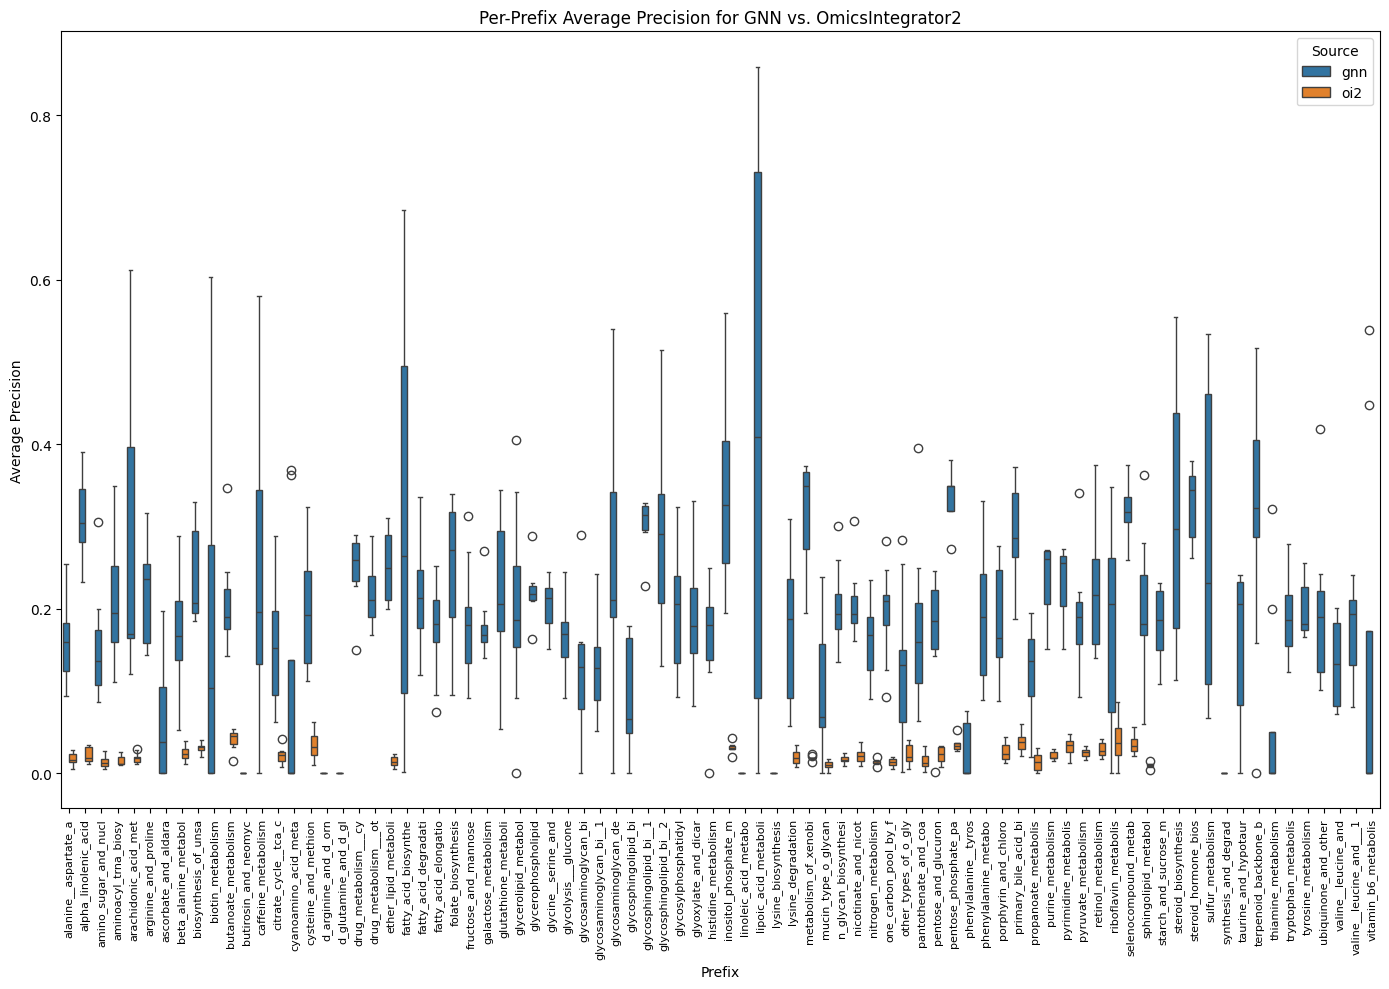

In [17]:
# 3) draw the boxplot
plt.figure(figsize=(14,10))
sns.boxplot(
    data=long,
    x='pathway',
    y='average_precision',
    hue='source',
    order=order,
    palette={'oi2':'#FF7F0E','gnn':'#1F77B4'}
)
plt.xticks(rotation=90, fontsize=8)
plt.xlabel("Prefix")
plt.ylabel("Average Precision")
plt.title("Per-Prefix Average Precision for GNN vs. OmicsIntegrator2")
plt.legend(title="Source")
plt.tight_layout()
plt.show()